In [ ]:
!pip install pytorch-accelerated

In [ ]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [ ]:
!pip install ipywidgets

In [ ]:
## nnAudio
!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

In [ ]:
!pip install timm

In [ ]:
!pip install torchmetrics

In [33]:
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import config
from glob import glob

from tqdm.notebook import tqdm

import random
import math
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from pytorch_accelerated import Trainer

import timm

import torchaudio
import torchaudio.transforms as AT
import torchvision.transforms as VT
from nnAudio import features

from timm.loss import LabelSmoothingCrossEntropy
import timm.optim

from torchmetrics import MetricCollection, Accuracy, Precision, Recall
from sklearn.metrics import accuracy_score

from evaluate_torch import get_results, evaluate_model_timestamp

# Evaluation with PSDS
from eval import do_eval 

In [ ]:
# trainer class
class TrainerWithMetrics(Trainer):
    def __init__(self, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # this will be moved to the correct device automatically by the
        # MoveModulesToDeviceCallback callback, which is used by default
        self.metrics = MetricCollection(
            {
                "accuracy": Accuracy(num_classes=num_classes),
                "precision": Precision(num_classes=num_classes),
                "recall": Recall(num_classes=num_classes),
            }
        )
    
    def calculate_train_batch_loss(self, batch):
        xb, yb = batch[0], batch[1]

        model_outputs = self.model(xb)
        loss = self.loss_func(model_outputs['prediction'], yb)

        return {
            "loss": loss,
            "model_outputs": model_outputs,
            "batch_size": yb.size(0),
        }
    
    def calculate_eval_batch_loss(self, batch):
        with torch.no_grad():
            xb, yb = batch[0], batch[1]
            model_outputs = self.model(xb)
            val_loss = self.loss_func(model_outputs['prediction'], yb)

        batch_output = {
            "loss": val_loss,
            "model_outputs": model_outputs,
            "batch_size": yb.size(0),
        }
        preds = batch_output["model_outputs"]['prediction'].argmax(dim=-1)

        self.metrics.update(preds, batch[1])

        return batch_output

    def eval_epoch_end(self):
        metrics = self.metrics.compute()
        self.run_history.update_metric("accuracy", metrics["accuracy"].cpu())
        self.run_history.update_metric("precision", metrics["precision"].cpu())
        self.run_history.update_metric("recall", metrics["recall"].cpu())

        self.metrics.reset()

In [ ]:
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _, row in tqdm(df.iterrows(), total=len(df)):
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'index':row.name,'id':row['id'], 'offset':0,'sound_type': row['sound_type'], 'length': row['length']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'index':row.name, 'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate),'sound_type':row['sound_type'], 'length': row['length']})
        elif short_audio:
            audio_offsets.append({'index':row.name,'id':row['id'], 'offset':0,'sound_type': row['sound_type'], 'length': row['length']})
    return pd.DataFrame(audio_offsets)       

In [ ]:
df = pd.read_csv(config.data_df)

# To be kept: please do not edit the dev set: these paths select dev set a, dev set b as described in the paper
idx_dev_a = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'field')
idx_dev_b = np.logical_and(df['country'] == 'UK', df['location_type'] == 'culture')
idx_train = np.logical_not(np.logical_or(idx_dev_a, idx_dev_b))
df_dev_a = df[idx_dev_a]
df_dev_b = df[idx_dev_b]


df_train = df[idx_train]

# Modify by addition or sub-sampling of df_train here
# df_train ... 

# Assertion to check that train does NOT appear in dev:
assert len(np.where(pd.concat([df_train,df_dev_a,
                               df_dev_b]).duplicated())[0]) == 0, 'Train dataframe contains overlap with dev A, dev B'

In [ ]:
print(config.NFFT, config.win_size, config.n_hop, config.step_size)
print((config.win_size * config.n_hop) / config.rate)

In [ ]:
config.NFFT = 1024
config.win_size = 360
config.n_hop = config.NFFT//8
config.step_size = config.win_size//3

In [ ]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

In [ ]:
# step min length
(config.step_size * config.n_hop) / config.rate

In [ ]:
# come on feel the noise

# first get the length of all the MUSAN noises https://www.openslr.org/17/ --> data/noise
files_noise = glob('../../HumBugDB/data/noise/**/*.wav')+glob('../../HumBugDB/data/audioset/*.wav')
df_noise = pd.DataFrame([{'path': f, 'length': torchaudio.sox_effects.apply_effects_file(f, effects=[["rate", f'{config.rate}']])[0].shape[1]/config.rate} for f in tqdm(files_noise)])
# make the noise in the training data match the format
df_noise_train = df_train[(df_train['sound_type']!='mosquito')][['id','length']]
df_noise_train = df_noise_train[df_noise_train['length']>min_length].sample(frac=0.19)
df_noise_train['path'] = df_noise_train['id'].apply(lambda x: os.path.join(config.data_dir_train,f'{x}.wav'))
df_noise = pd.concat([df_noise,df_noise_train[['path','length']]],ignore_index=True)

In [ ]:
# use audio clips shorter than min length ?
USE_SHORT_AUDIO = True
# get the frame offsets for each audio file into dataframes
audio_df_train = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
audio_df_test_A = get_offsets_df(df_dev_a, short_audio=True)
audio_df_test_B = get_offsets_df(df_dev_b, short_audio=True)

In [ ]:
class MozTrainDataset(Dataset):

    def __init__(self, audio_df, noise_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        if self.cache is not None and path in self.cache:
            return self.cache[path], resample
        else:
            effects = [
                ["remix", "1"]
            ]
            if resample:
                effects.extend([
                 ["rate", f'{resample}'],
                  ['gain', '-n'],
                ["highpass", "500"],
                ])

            waveform, rate = torchaudio.sox_effects.apply_effects_file(path, effects=effects)
            if waveform.shape[1] < config.rate*self.min_length:
                r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
                f = torch.cat([waveform for _ in range(r)],dim=1)[:,:int(config.rate*self.min_length)][0]
            else:    
                f = waveform[0]
            mu = torch.std_mean(f)[1]
            st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
            #f = f_out.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out, rate

    def __getitem__(self, idx):
        real_idx = idx % len(self.audio_df)
        x, _ = self._get_sample_(os.path.join(self.data_dir,f"{self.audio_df.loc[real_idx]['id']}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        #if real_idx % 2 == 0 and self.audio_df.loc[real_idx]['sound_type'] == 'mosquito':
        #if self.audio_df.loc[real_idx]['sound_type'] == 'mosquito' and random.randint(0,1)==1:
        if random.randint(0,1)==2:
            sample_length = x.shape[1]/config.rate#sample_length = self.audio_df.loc[real_idx]['length']
            if len(self.noise_df[self.noise_df['length'] >= sample_length]) > 0:
                noise_path = self.noise_df[self.noise_df['length'] >= sample_length].sample(1).iloc[0]['path']
                noise, _ = self._get_sample_(noise_path, resample=config.rate)
                
                noise_length_difference = noise.shape[1]-x.shape[1] 
                
                random_noise_offset = 0 if noise_length_difference==0 else random.randrange(0,noise_length_difference)
                noise = noise[:, random_noise_offset:random_noise_offset+x.shape[1]]

                mos_power = x.norm(p=2)
                noise_power = noise.norm(p=2)

                snr = math.exp(random.randint(2,5) / 10)
                
                scale = snr * noise_power / mos_power
                x = (scale * x + noise) / 2
        
        offset = self.audio_df.loc[real_idx]['offset']
        return (x[:,offset:int(offset+config.rate*self.min_length)], torch.tensor(1) if self.audio_df.loc[real_idx]['sound_type'] == 'mosquito' else torch.tensor(0), idx)


In [ ]:
class MozTestDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        if self.cache is not None and path in self.cache:
            return self.cache[path], resample
        else:
            effects = [
                ["remix", "1"]
            ]
            if resample:
                effects.extend([
                  ["rate", f'{resample}'],
                  ['gain', '-n'],
                ["highpass", "200"],
                ])
            waveform, rate = torchaudio.sox_effects.apply_effects_file(path, effects=effects)
            if waveform.shape[1] < config.rate*self.min_length:
                left_pad_amt = int((config.rate*min_length-waveform.shape[1])//2)
                left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
                right_pad_amt = int(config.rate*min_length-waveform.shape[1]-left_pad_amt)
                right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
                f = torch.cat([left_pad,waveform,right_pad],dim=1)[0]
                f = ((0.0001**0.5)*torch.randn(1, int(config.rate*min_length))+f)[0]
#                 r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
#                 f = torch.cat([waveform for _ in range(r)],dim=1)[:,:int(config.rate*self.min_length)][0]
            else:    
                f = waveform[0]
            mu = torch.std_mean(f)[1]
            st = torch.std_mean(f)[0]
            #return waveform, rate, waveform
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
#             f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out, rate

    def __getitem__(self, idx):
        real_idx = idx % len(self.audio_df)
        x, _ = self._get_sample_(os.path.join(self.data_dir,f"{self.audio_df.loc[real_idx]['id']}.wav"), resample=config.rate)
        
        
        
        offset = self.audio_df.loc[real_idx]['offset']
        return x[:,offset:int(offset+config.rate*self.min_length)], torch.tensor(1) if self.audio_df.loc[real_idx]['sound_type'] == 'mosquito' else torch.tensor(0), idx
    
    

In [ ]:
# initialize empty cache
# it would be great if this was something cooler than a dictionary
audio_cache={}

In [ ]:
valid_size = 0.2
shuffle = True
random_seed = 42
min_length = (config.win_size * config.n_hop) / config.rate
# needed for cache

num_workers=0
pin_memory=True

num_train = len(audio_df_train)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_dataset = MozTrainDataset(audio_df_train, df_noise, config.data_dir_train, min_length, audio_cache)

val_dataset = MozTrainDataset(audio_df_train, df_noise, config.data_dir_train, min_length, audio_cache)

In [34]:
batch_size = 32

dataset_test_A = MozTestDataset(audio_df_test_A, config.data_dir_dev_a, min_length, audio_cache)

test_loader_A = torch.utils.data.DataLoader(
        dataset_test_A, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

dataset_test_B = MozTestDataset(audio_df_test_B, config.data_dir_dev_b, min_length, audio_cache)

test_loader_B = torch.utils.data.DataLoader(
        dataset_test_B, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

In [ ]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [ ]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [ ]:
def evaluate_model(model, test_loader, n_samples, n_channels=3):
    with torch.no_grad():
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f'Evaluating on {device}')

        softmax = nn.Softmax(dim=1)
        
        y_preds_all = torch.zeros([n_samples, len(test_loader.dataset), 2])
        model.eval() # Important to not leak info from batch norm layers and cause other issues
        
        for n in range(n_samples):
            all_y_pred = []
            all_y = []
            for x, y, idx in tqdm(test_loader):
                x, y = x.to(device), y.to(device)

                y_pred = model(x)['prediction']
                all_y.append(y.cpu().detach())

                all_y_pred.append(y_pred.cpu().detach())

                del x
                del y
                del y_pred

            all_y_pred = torch.cat(all_y_pred)
            all_y = torch.cat(all_y)

            y_preds_all[n,:] = softmax(all_y_pred)
#             y_preds_all[n,:,1] = np.array(sigmoid(all_y_pred).squeeze())
#             y_preds_all[n,:,0] = 1-np.array(sigmoid(all_y_pred).squeeze()) # Check ordering of classes (yes/no)
            test_acc = accuracy_score(all_y.numpy(), torch.argmax(all_y_pred,dim=1).numpy())
            print(test_acc)
    return y_preds_all, all_y

In [ ]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=2, in_chans=1, 
                        drop_path_rate=0.1, global_pool='avgmax',
                        drop_rate=0.1)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
        for name, param in self.backbone.named_parameters():
            if param.requires_grad and 'head' not in name \
                and not name.startswith('norm') \
                and 'stages.3' not in name and 'layers.3' not in name \
                and 'blocks.26' not in name and 'blocks.26' not in name \
                and 'blocks.24' not in name and 'blocks.25' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.20' not in name and 'blocks.21' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.19' not in name and 'blocks.18' not in name \
                and 'blocks.17' not in name and 'blocks.5.' not in name:
                param.requires_grad = False
        #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='log2', center=True, pad_mode='reflect',
                          fmin=300, fmax=3000, sr=config.rate, output_format="Magnitude", trainable=True)
#         self.spec_layer = features.MelSpectrogram(n_fft=config.NFFT, n_mels=128, hop_length=config.n_hop,
#                                 window='hann',  center=True, pad_mode='reflect',
#                           sr=config.rate,  trainable_mel=True, trainable_STFT=True)
#         self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = AT.TimeMasking(time_mask_param=30, iid_masks=True)
        self.freqMasking = AT.FrequencyMasking(freq_mask_param=20, iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        spec = self.norm_layer(spec)
        
#         if self.training:
#             spec = self.timeMasking(spec)
#             spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        pred = self.backbone(x)
        pred = self.softmax(pred)
#        pred = self.out(x)
        
        output = {"prediction": pred,
                  "spectrogram": spec}
        return output

In [ ]:
# this is how you train
model = Model('convnext_base_384_in22ft1k',384)
loss_func = LabelSmoothingCrossEntropy(smoothing=0.1)
optimizer = timm.optim.create_optimizer_v2(model,opt='lamb',lr=0.001,weight_decay=0.01)
num_classes =2 

trainer = TrainerWithMetrics(
    model=model, loss_func=loss_func, optimizer=optimizer, num_classes=num_classes
)


trainer.train(
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    num_epochs=2,
    per_device_batch_size=32,
)

In [ ]:
# optional, save model
torch.save(model.state_dict(), '../models/VecNet_2020_06_02')

In [ ]:
# optional, load model
model = Model('convnext_base_384_in22ft1k',384)
model.load_state_dict(torch.load('../models/VecNet_2020_06_02'))
model.eval()

In [ ]:
model_name = 'VecNet_2022_06_02'

In [ ]:
feat_type='VecNet_2022_06_02'

In [ ]:
# Evaluate over dev A

In [ ]:
# clear old predictions if necessary
!rm -rf ../data/predictions/dev/a
mkdir ../data/predictions/dev/a

In [ ]:
# Evaluate over dev A
evaluate_model_timestamp('.wav','../data/audio/dev/a','../data/predictions/dev/a', 2, model=model,
                         win_size=config.win_size, step_size=config.step_size, n_hop=config.n_hop, debug=False)

In [ ]:
do_eval('./data/predictions/dev/a', './data/labels/dev/a', filename = os.path.join(config.plot_dir, model_name + "_dev_a.png"))

In [ ]:
y_preds_all, y_test_A = evaluate_model(model, test_loader_A, 1, n_channels=1)  # Predict directly over feature windows (1.92 s)
PE, MI, log_prob = get_results(y_preds_all.numpy(), y_test_A, filename = feat_type + '_' + model_name +'_Test_A')

In [ ]:
# Evaluate over dev B

In [ ]:
# clear old predictions if necessary
!rm -rf ../data/predictions/dev/b
mkdir ../data/predictions/dev/b

In [ ]:
evaluate_model_timestamp('.wav','../data/audio/dev/b','../data/predictions/dev/b', 2, model=model,
                         win_size=config.win_size, step_size=config.step_size, n_hop=config.n_hop, debug=False)

In [ ]:
do_eval('./data/predictions/dev/b', './data/labels/dev/b', filename = os.path.join(config.plot_dir, model_name + "_dev_b.png"))

Evaluating on cuda:0


  0%|          | 0/37 [00:00<?, ?it/s]

0.7601694915254237


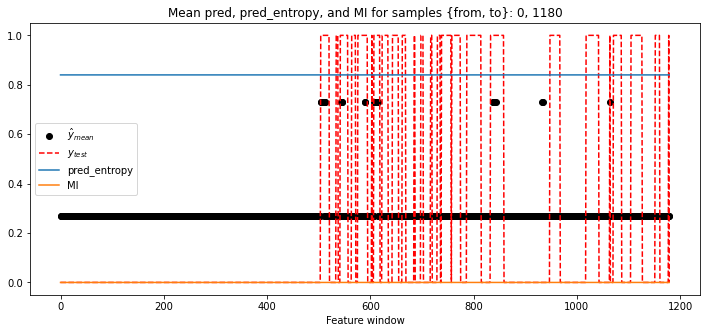

mean ROC AUC: 0.5461510908134368


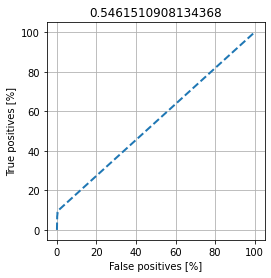

std ROC AUC: 0.0
PR-AUC:  0.3265682476181413


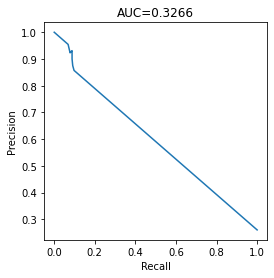

Confusion matrix, as input by user
[[99.7709  0.2291]
 [91.5309  8.4691]]


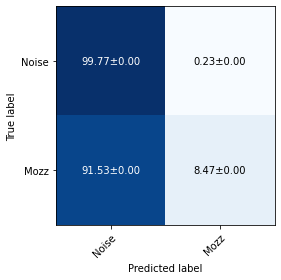

In [35]:
y_preds_all, y_test_B = evaluate_model(model, test_loader_B, 1, n_channels=1)  # Predict directly over feature windows (1.92 s)
PE, MI, log_prob = get_results(y_preds_all.numpy(), y_test_B, filename = feat_type + '_' + model_name +'_Test_B')